In [1]:
import gym
import random
import numpy as np 
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from statistics import mean
from timeit import default_timer as timer
import seaborn as sns

from mdptoolbox import example
from mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

In [2]:
env_name = "FrozenLake8x8-v1"
map_name = "4x4"

In [3]:
env = gym.make(env_name,
               map_name=map_name)

p,r  = example.openai(env_name = env_name, 
                      map_name = map_name)

# Common Functions

In [4]:
def check_policy(env, policy, episodes,gamma):

    misses = 0
    goal_reached = 0
    total_reward = []
    total_steps = []

    for e in range(episodes):

        observation = env.reset()
        steps_taken = 0
        internal_reward = 0

        while True:

            observation, reward, done, _ = env.step(policy[observation])
            
            #Discounted reward = r_1 + 𝛾 r_2 + 𝛾² r_3 + 𝛾³ r_4 + 𝛾⁴ r_5+ …
            internal_reward = internal_reward + ((gamma**steps_taken)*reward)

            steps_taken = steps_taken + 1

            if done:
                total_reward.append(internal_reward)
                
                if reward == 1:
                    total_steps.append(steps_taken)
                    goal_reached = goal_reached + 1
                    break

                elif reward == 0:
                    misses = misses + 1
                    break
                    
    print(f"Average steps: {np.mean(total_steps)} | Average Rewards: {np.mean(total_reward)} | Holes : {misses} | Goals : {goal_reached}")
    return np.mean(total_steps),np.mean(total_reward),misses,goal_reached

    

def plot_best_policy(X,Y):
  
    plt.plot(X,Y)  
    plt.title("Iterations VS Mean V values")
    plt.xlabel("Iterations")
    plt.ylabel("Mean V values")
    plt.show()  

def plot_diff_meanv_policy(X,Y):
  
    plt.plot(X,Y)  
    plt.title("Iterations VS Change in value function")
    plt.xlabel("Iterations")
    plt.ylabel("Change in value function")
    plt.show()  

def convert_to_four_by_four(data):
    return [data[0:4],data[4:8],data[8:12],data[12:]]

def plot_frozen_lake_policy(policy):

    directions = {0: '←',1: '↓',2: '→',3: '↑'}

    data = convert_to_four_by_four(policy)
    
    labels =  convert_to_four_by_four([directions[i] for i in policy])

    fig, ax = plt.subplots()

    ax = sns.heatmap(data, annot = labels, fmt = '')    

# Value Iteration

In [5]:
discount_list = [0.9,0.95,0.995,0.999]
epsilon_list = [1e-3, 1e-6, 1e-9, 1e-12]
max_iterations = 50

In [6]:
li = []

for discount in discount_list:
    for epsilon in epsilon_list:
        print(f"Running VI for Discount factor : {discount} | Epsilon : {epsilon}")

        vi = ValueIteration(p,r,
                            gamma = discount,
                            max_iter = max_iterations,
                            epsilon = epsilon)
        ret = vi.run()
        policy_vi = list(vi.policy)
        converged_iterations = vi.iter
        
        max_v = ret[-1]['Max V']
        
        avg_vf = np.mean(vi.V)
        
        max_rewards, mean_rewards = [], []
        for run in ret:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])    
            
            
        mean_steps,mean_rewards_100,misses,goal_reached = check_policy(env, policy_vi, 100,discount)

        li.append([discount,epsilon,
                   max_v,mean(mean_rewards),avg_vf,
                   converged_iterations,policy_vi,mean_rewards,max_rewards,
                   mean_steps,mean_rewards_100,misses,goal_reached])

Running VI for Discount factor : 0.9 | Epsilon : 0.001
Average steps: 42.5125 | Average Rewards: 0.07941245270230476 | Holes : 20 | Goals : 80
Running VI for Discount factor : 0.9 | Epsilon : 1e-06
Average steps: 44.753246753246756 | Average Rewards: 0.06841486517901042 | Holes : 23 | Goals : 77
Running VI for Discount factor : 0.9 | Epsilon : 1e-09
Average steps: 44.3780487804878 | Average Rewards: 0.06716448168530076 | Holes : 18 | Goals : 82
Running VI for Discount factor : 0.9 | Epsilon : 1e-12
Average steps: 46.0 | Average Rewards: 0.06245395450847505 | Holes : 22 | Goals : 78
Running VI for Discount factor : 0.95 | Epsilon : 0.001
Average steps: 40.822784810126585 | Average Rewards: 0.19540056033433 | Holes : 21 | Goals : 79
Running VI for Discount factor : 0.95 | Epsilon : 1e-06
Average steps: 48.7125 | Average Rewards: 0.15957653171204864 | Holes : 20 | Goals : 80
Running VI for Discount factor : 0.95 | Epsilon : 1e-09
Average steps: 44.65384615384615 | Average Rewards: 0.18131

In [108]:
df_VI = pd.DataFrame(li,
                     columns = ['Discount factor','Epsilon',
                                'max V','Avg Mean V','Avg VF',
                                'Iterations','Policy',
                                'mean_rewards_li','max_rewards_li','mean_steps',
                                'mean_rewards_100','misses','goal_reached'])

In [123]:
df_VI.rename(columns={'mean_rewards_100':'Mean Rewards','mean_steps':'Mean steps'},inplace = True)

In [124]:
df_VI[['Discount factor','Epsilon','Iterations','Mean steps','Mean Rewards','misses','goal_reached']]

,Discount factor,Epsilon,Iterations,Mean steps,Mean Rewards,misses,goal_reached
0,0.900,1.000000e-03,27,45.742857,0.052591,30,70
1,0.900,1.000000e-06,78,45.234568,0.076113,19,81
2,0.900,1.000000e-09,129,34.506173,0.089605,19,81
3,0.900,1.000000e-12,179,47.485294,0.062124,32,68
4,0.950,1.000000e-03,44,46.462500,0.174382,20,80
5,0.950,1.000000e-06,128,40.821918,0.183081,27,73
6,0.950,1.000000e-09,213,42.037975,0.205484,21,79
7,0.950,1.000000e-12,297,40.987500,0.183272,20,80
8,0.995,1.000000e-03,124,49.916667,0.668870,16,84
9,0.995,1.000000e-06,357,50.178571,0.666482,16,84


In [110]:
vi = ValueIteration(p,r,
                    gamma = 0.999,
                    max_iter = max_iterations,
                    epsilon = 1e-06)
ret = vi.run()
policy_vi = list(vi.policy)
converged_iterations = vi.iter

In [111]:
check_policy(env, policy_vi, 100, 0.999)

Average steps: 46.75 | Average Rewards: 0.8029471258492359 | Holes : 16 | Goals : 84


(46.75, 0.8029471258492359, 16, 84)

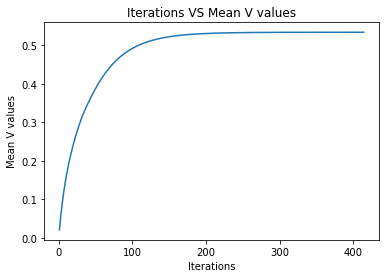

In [112]:
mean_v = [i['Mean V'] for i in ret]
iterations = [i['Iteration'] for i in ret]
plot_best_policy(iterations,mean_v)

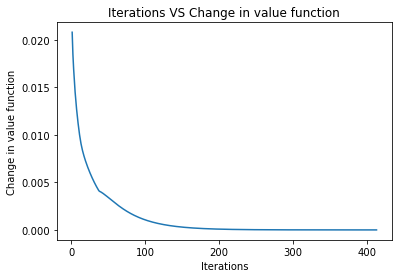

In [113]:
diff_mean_Vs = [j-i for i, j in zip(mean_v[:-1], mean_v[1:])] 
plot_diff_meanv_policy(iterations[0:-1],diff_mean_Vs)

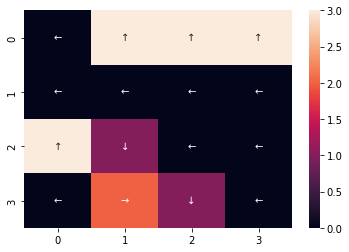

In [33]:
plot_frozen_lake_policy(policy_vi)

# Policy Iteration

In [114]:
discount_list = [0.8,0.9,0.95,0.995,0.999]
eval_type_list = [0,1]
max_iterations = 500

In [115]:
li = []
for discount in discount_list:
    for eval_type in eval_type_list:

        print(f"Running VI for Discount factor : {discount} | Eval type : {eval_type}")

        pi = PolicyIteration(p,r,
                            gamma  = discount,
                            eval_type = eval_type, 
                            max_iter = max_iterations
                            )
        ret = pi.run()
        policy_pi = list(pi.policy)
        converged_iterations = pi.iter
        
        max_v  = ret[-1]['Max V']
        avg_vf = np.mean(pi.V)
        
        max_rewards, mean_rewards = [], []
        for run in ret:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])    

        li.append([discount,eval_type,max_v,mean(mean_rewards),avg_vf,converged_iterations,policy_vi,mean_rewards,max_rewards])

Running VI for Discount factor : 0.8 | Eval type : 0
Running VI for Discount factor : 0.8 | Eval type : 1
Running VI for Discount factor : 0.9 | Eval type : 0
Running VI for Discount factor : 0.9 | Eval type : 1
Running VI for Discount factor : 0.95 | Eval type : 0
Running VI for Discount factor : 0.95 | Eval type : 1
Running VI for Discount factor : 0.995 | Eval type : 0
Running VI for Discount factor : 0.995 | Eval type : 1
Running VI for Discount factor : 0.999 | Eval type : 0
Running VI for Discount factor : 0.999 | Eval type : 1


In [116]:
df_PI = pd.DataFrame(li,
                     columns = ['Discount factor','Eval type',
                                'max V','Avg Mean V','Avg VF',
                                'Iterations','Policy',
                                'mean_rewards_li','max_rewards_li'])

In [118]:
df_PI[['Discount factor','Eval type','max V','Avg Mean V','Avg VF','Iterations']]

,Discount factor,Eval type,max V,Avg Mean V,Avg VF,Iterations
0,0.800,0,0.544196,0.065391,0.083778,3
1,0.800,1,0.544175,0.071456,0.083745,5
2,0.900,0,0.639020,0.106186,0.136006,5
3,0.900,1,0.639006,0.105852,0.135976,5
4,0.950,0,0.723674,0.142080,0.205505,5
5,0.950,1,0.723662,0.142456,0.205481,5
6,0.995,0,0.896781,0.281185,0.461835,6
7,0.995,1,0.896779,0.277599,0.461829,6
8,0.999,0,0.931179,0.530166,0.533481,500
9,0.999,1,0.931178,0.305790,0.533479,6


In [119]:
pi = PolicyIteration(p,r,
                    gamma  = 0.999,
                    eval_type = 1, 
                    max_iter = max_iterations
                    )
ret = pi.run()
policy_pi = list(pi.policy)

In [120]:
check_policy(env, policy_vi, 100, 0.999)

Average steps: 56.566265060240966 | Average Rewards: 0.785718676977932 | Holes : 17 | Goals : 83


(56.566265060240966, 0.785718676977932, 17, 83)

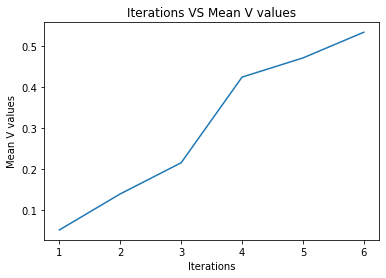

In [121]:
mean_v = [i['Mean V'] for i in ret]
iterations = [i['Iteration'] for i in ret]
plot_best_policy(iterations,mean_v)

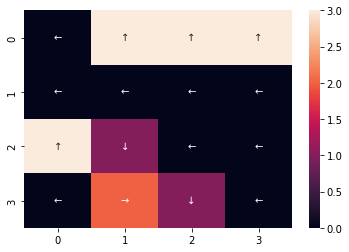

In [122]:
plot_frozen_lake_policy(policy_pi)

In [125]:
policy_pi

[0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]

# Q Learning

In [43]:
def run_q_learning(learning_rate,gamma,epsilon_decay):

    rewards = []
    total_episodes = 20000
    max_steps = 100
    epsilon = 1.0        
    max_epsilon = 1.0             
    min_epsilon = 0.01    
    qtable = np.zeros((16, 4))

    for episode in range(total_episodes):

        state = env.reset()

        step = 0
        done = False
        total_rewards = 0

        for step in range(max_steps):

            random_number  = random.uniform(0, 1)

            # exploitation (biggest Q value for the state)
            if random_number > epsilon:
                action = np.argmax(qtable[state,:])

            # exploration
            else:
                action = env.action_space.sample()

            # new state (s') and reward (r)
            new_state, reward, done, _ = env.step(action)

            # Q(s,a) = Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards = total_rewards +  reward

            state = new_state

            if done == True: 
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode) 

        rewards.append(total_rewards)

    return sum(rewards)/total_episodes,qtable

In [81]:
learning_rate_list = [0.1,0.4,0.6,0.8]
gamma_list = [0.9,0.95]
epsilon_decay_list = [0.001]

In [82]:
q_li = []
for learning_rate in learning_rate_list:
    for gamma in gamma_list:
        
        for epsilon_decay in epsilon_decay_list:
            
            print(f"Learning rate {learning_rate} | Gamma : {gamma} | Epsilon delay : {epsilon_decay}")
            
            avg_rewards,qtable = run_q_learning(learning_rate,gamma,epsilon_decay)
            
            q_li.append([learning_rate,gamma,epsilon_decay,avg_rewards,qtable])
            
q_learning_df = pd.DataFrame(q_li,columns = ['Learning rate','Gamma','Epsilon Decay','Average Rewards','Q Table'])

Learning rate 0.1 | Gamma : 0.9 | Epsilon delay : 0.001
Learning rate 0.1 | Gamma : 0.95 | Epsilon delay : 0.001
Learning rate 0.4 | Gamma : 0.9 | Epsilon delay : 0.001
Learning rate 0.4 | Gamma : 0.95 | Epsilon delay : 0.001
Learning rate 0.6 | Gamma : 0.9 | Epsilon delay : 0.001
Learning rate 0.6 | Gamma : 0.95 | Epsilon delay : 0.001
Learning rate 0.8 | Gamma : 0.9 | Epsilon delay : 0.001
Learning rate 0.8 | Gamma : 0.95 | Epsilon delay : 0.001


In [83]:
q_learning_df.sort_values(by = ['Average Rewards'],ascending = [False])

,Learning rate,Gamma,Epsilon Decay,Average Rewards,Q Table
1,0.1,0.95,0.001,0.54635,"[[0.17695709582450558, 0.16255491651900558, 0...."
3,0.4,0.95,0.001,0.47400,"[[0.14303850581380542, 0.11583380230469878, 0...."
5,0.6,0.95,0.001,0.44890,"[[0.1618043585040053, 0.14175948528166007, 0.0..."
0,0.1,0.90,0.001,0.44115,"[[0.057342157291215515, 0.04544634478035232, 0..."
7,0.8,0.95,0.001,0.41960,"[[0.24764536867546574, 0.08496787086668134, 0...."
6,0.8,0.90,0.001,0.37385,"[[0.006969789411469888, 0.006927320316050981, ..."
4,0.6,0.90,0.001,0.37065,"[[0.03421379035088805, 0.030584254850054775, 0..."
2,0.4,0.90,0.001,0.36330,"[[0.03581170468349564, 0.09092954233709635, 0...."


In [84]:
qtable =q_learning_df[q_learning_df['Average Rewards'] ==0.54635]['Q Table'].values.tolist()[0]

In [93]:
env.reset()
goals = 0
holes = 0
steps = []
for episode in range(100):
    
    state = env.reset()
    step = 0
    done = False

    for step in range(1000):
        
        action = np.argmax(qtable[state,:])

        new_state, reward, done, info = env.step(action)
        
        if done:

            if new_state == 15:
                goals = goals + 1
            else:
                holes = holes + 1

            steps.append(step)
            
            break
        state = new_state

In [94]:
print(goals,holes)

82 18
